# Explore Re-weighting Schemes
Our TD-DFT data is heavily biased. We only have a small amount of it, and it is collected along fixed vectors in the search space. As a result, our model is biased. In these notebooks, we explore whether we can re-weight the training data according to this bias in order to make a less-biased model.

For this notebook, our goal is to implement a few strategies for re-weighting the data and will test the weightings in a different notebook

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity, NearestNeighbors
from cvxopt import matrix, solvers
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

## Load in the Target Space and Training Data
The sample space produced in the manifold task can be used to describe out search space

In [2]:
target_space = pd.read_pickle(os.path.join('..', 'sampled_space.pkl.gz'))
print('Imported a target space of {} entries'.format(len(target_space)))

Imported a target space of 16384 entries


In [3]:
train_data = pd.read_pickle(os.path.join('..', '..', 'data', 'random_data.pkl.gz')).query('not initial')
print('Imported a training set of {} entries'.format(len(train_data)))

Imported a training set of 9379 entries


In [4]:
with open(os.path.join('..', 'manifold_features.pkl'), 'rb') as fp:
    manifold_features = pkl.load(fp)

In [5]:
with gzip.open(os.path.join('..', 'manifold.pkl.gz')) as fp:
    manifold = pkl.load(fp)

## Reweight Based on Sample Density Estimates
We can use Kernel Density Measurements to develop a probability distribution of the sampled and training data. Then, the optimal weight for the training data is the ratio between the new probability distribution at that point

In [6]:
def get_average_nn_dist(dataset, n=10):
    """Get the average nearest neighbor distance for a dataset
    
    Args:
        dataset (pd.DataFrame): Dataset in question
    Returns:
        (float) The average NN distance
    """
    return NearestNeighbors(n_neighbors=2).fit(dataset).kneighbors(dataset)[0].max(axis=1).mean()

Train the kernel density estimator for the training set and target space. Use the average NN distance as the bandwidth for the kernel

In [7]:
train_kde = KernelDensity(bandwidth=get_average_nn_dist(train_data[manifold_features]) * 4).fit(train_data[manifold_features])

In [8]:
target_kde = KernelDensity(bandwidth=get_average_nn_dist(target_space[manifold_features]) * 4).fit(target_space[manifold_features])

Score each entry in the training dataset with both distributions

In [9]:
%%time
train_scores = train_kde.score_samples(train_data[manifold_features])

CPU times: user 7.91 s, sys: 112 ms, total: 8.02 s
Wall time: 6.36 s


In [10]:
%%time
target_scores = target_kde.score_samples(train_data[manifold_features])

CPU times: user 15.8 s, sys: 57.3 ms, total: 15.8 s
Wall time: 15.7 s


The desired weight is $Target(X)/Train(X)$. The score samples use the log values. So, the weight is equal to $e^{log(Target) - log(Train)}$

In [11]:
train_data['kde_weight'] = np.exp(target_scores - train_scores)

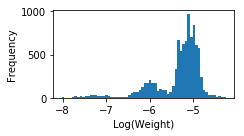

In [12]:
fig, ax = plt.subplots()

ax.hist(np.log10(train_data['kde_weight']), bins=64)

ax.set_xlabel('Log(Weight)')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Note*: Setting the kernel width was an iterative process. I adjusted it until I had somehwat smooth points on the plot below. The thought was I did not want the Kernel to be too small

### Analyze Weights
What kind of entries are we weighing higher?

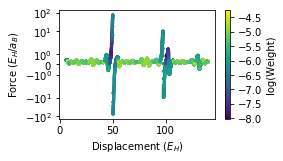

In [13]:
fig, ax = plt.subplots()

line = ax.scatter(train_data['displacement'], train_data['force'], c=np.log10(train_data['kde_weight']), s=5)

ax.set_yscale('symlog')

ax.set_ylabel('Force ($E_H / a_B$)')
ax.set_xlabel('Displacement ($E_H$)')

cax = fig.colorbar(line)
cax.set_label('log(Weight)')
fig.set_size_inches(3.5, 2)
fig.savefig(os.path.join('figures', 'random-traj-kde-weights.png'), dpi=320)

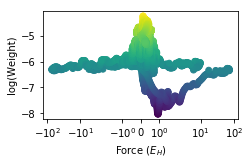

In [14]:
fig, ax = plt.subplots()

ax.scatter(train_data['force'], np.log10(train_data['kde_weight']), c=np.log10(train_data['kde_weight']))

ax.set_xscale('symlog')

ax.set_xlabel('Force ($E_H$)')
ax.set_ylabel('log(Weight)')
fig.set_size_inches(3.5, 2)

*Finding*: We weight the channel portions higher than the impacts

## Try Kernel Mean Matching
[Kernel Mean Matching](https://papers.nips.cc/paper/3075-correcting-sample-selection-bias-by-unlabeled-data.pdf) is an approach that does not require explicly defining a probability distribution.

In [15]:
def kernel_mean_matching(X, Z, kern='lin', B=1.0, eps=None):
    """Generate weights using Kernel Mean Matching
    
    Args:
        X (ndarray): Samples from target distribution
        Z (ndarray): Samples from training set 
        kern (string): Name of kernel to use
        B (float): Maximum value of weight
        eps (float): Unsure of the significant of this parameter
    Returns:
        (ndarray) Weights for the training data
    """
    # Taken from https://github.com/vodp/py-kmm
    nx = X.shape[0]
    nz = Z.shape[0]
    if eps == None:
        eps = B/np.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(nz)/float(nx),axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z,Z)
        kappa = np.sum(compute_rbf(Z,X),axis=1)*float(nz)/float(nx)
    else:
        raise ValueError('unknown kernel')
        
    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1,nz)), -np.ones((1,nz)), np.eye(nz), -np.eye(nz)])
    h = matrix(np.r_[nz*(1+eps), nz*(eps-1), B*np.ones((nz,)), np.zeros((nz,))])
    
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef

In [16]:
%%time
train_data['kmm_weight'] = kernel_mean_matching(target_space[manifold_features], train_data[manifold_features])

     pcost       dcost       gap    pres   dres
 0: -4.2747e+09 -4.2756e+09  4e+06  2e-02  1e-15
 1: -4.2747e+09 -4.2755e+09  3e+06  1e-02  8e-16
 2: -4.2747e+09 -4.2754e+09  2e+06  4e-03  6e-16
 3: -4.2747e+09 -4.2751e+09  8e+05  2e-03  6e-16
 4: -4.2746e+09 -4.2748e+09  6e+05  1e-03  6e-16
 5: -4.2746e+09 -4.2746e+09  3e+05  5e-04  6e-16
 6: -4.2745e+09 -4.2745e+09  1e+05  2e-04  6e-16
 7: -4.2745e+09 -4.2745e+09  5e+04  6e-05  7e-16
 8: -4.2745e+09 -4.2745e+09  3e+04  3e-05  7e-16
 9: -4.2745e+09 -4.2745e+09  1e+04  1e-05  1e-15
10: -4.2745e+09 -4.2745e+09  3e+03  3e-06  1e-15
11: -4.2745e+09 -4.2745e+09  2e+02  1e-07  3e-15
12: -4.2745e+09 -4.2745e+09  5e+00  2e-09  9e-15
Optimal solution found.
CPU times: user 17min 30s, sys: 1min 9s, total: 18min 40s
Wall time: 2min 31s


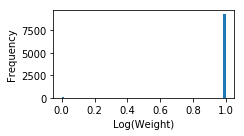

In [17]:
fig, ax = plt.subplots()

ax.hist(train_data['kmm_weight'], bins=64)

ax.set_xlabel('Log(Weight)')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)
fig.tight_layout()

*Finding*: We did not find interesting weights for this problem. They are all close to 1, which is the maximum allowed value.

## Save the Weights
Our next notebook will be to use them to train a model

In [18]:
train_data.to_pickle(os.path.join('data', 'random_data.pkl.gz'))